<a href="https://colab.research.google.com/github/GitMarco27/TMML/blob/main/Notebooks/011_Dtw_Loss_Function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3 Minutes Machine Learning
## FROM Episode 11: Dtw Loss Function

Slightly modified from
#### Marco Sanguineti, 2021
---


Tested on PC win1064-1036593 tf262 (note this is the lower case version!!)
18th August 2023

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
print(tf.__version__)
tf.config.list_physical_devices('GPU')

2.6.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Creating data

---
This works nicely


(500, 50)

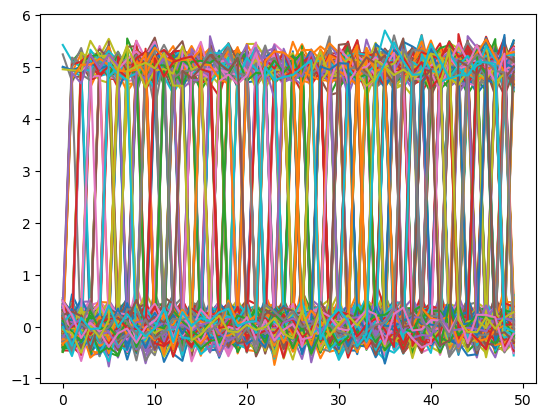

In [3]:
import random
n=50
records=500
noise_amplitude = 0.2  # Adjust the amplitude of the noise

xs=[]
ys=[]
for i in range(records):
    #Draw a straight line
    line = [0 for val in range(n)]
    opens = [5 for val in range(n)]
    # hHw many events?
    events = random.randint(0,5)
    lengths = np.random.randint(1,high=10,size=events)
    miin=0
    
    for event in range(events):
        if miin+lengths[event] < n:
            start = random.randint(miin,n-lengths[event])
            fin = start + lengths[event]
            miin = fin
            line[start:fin] = opens[start:fin]

    # Add noise to the sine wave            
    random_noise = np.random.normal(0, noise_amplitude, n)   

    xs.append(line + random_noise)
    ys.append(line)
    plt.plot(xs[i])
    
np.asarray(xs).shape


Create a couple of curves as actual tensors

In [4]:
#x = tf.Variable(np.cos(np.linspace(0, n)*3.14/180).reshape(1, -1))
#have made a load of them now
# WHY ARE WE making all these tf.variables if we just numpy them before run!!?
#x = tf.Variable(np.asarray(xs).reshape(batch_size,-1))
#y = tf.Variable(np.asarray(ys).reshape(batch_size,-1))
# Convert data to TensorFlow Tensors
x = tf.convert_to_tensor(np.asarray(xs).reshape(records,-1), dtype=tf.float32)
y = tf.convert_to_tensor(np.asarray(ys).reshape(records,-1), dtype=tf.float32)


For a look-see, convery back to numpy and plot'em

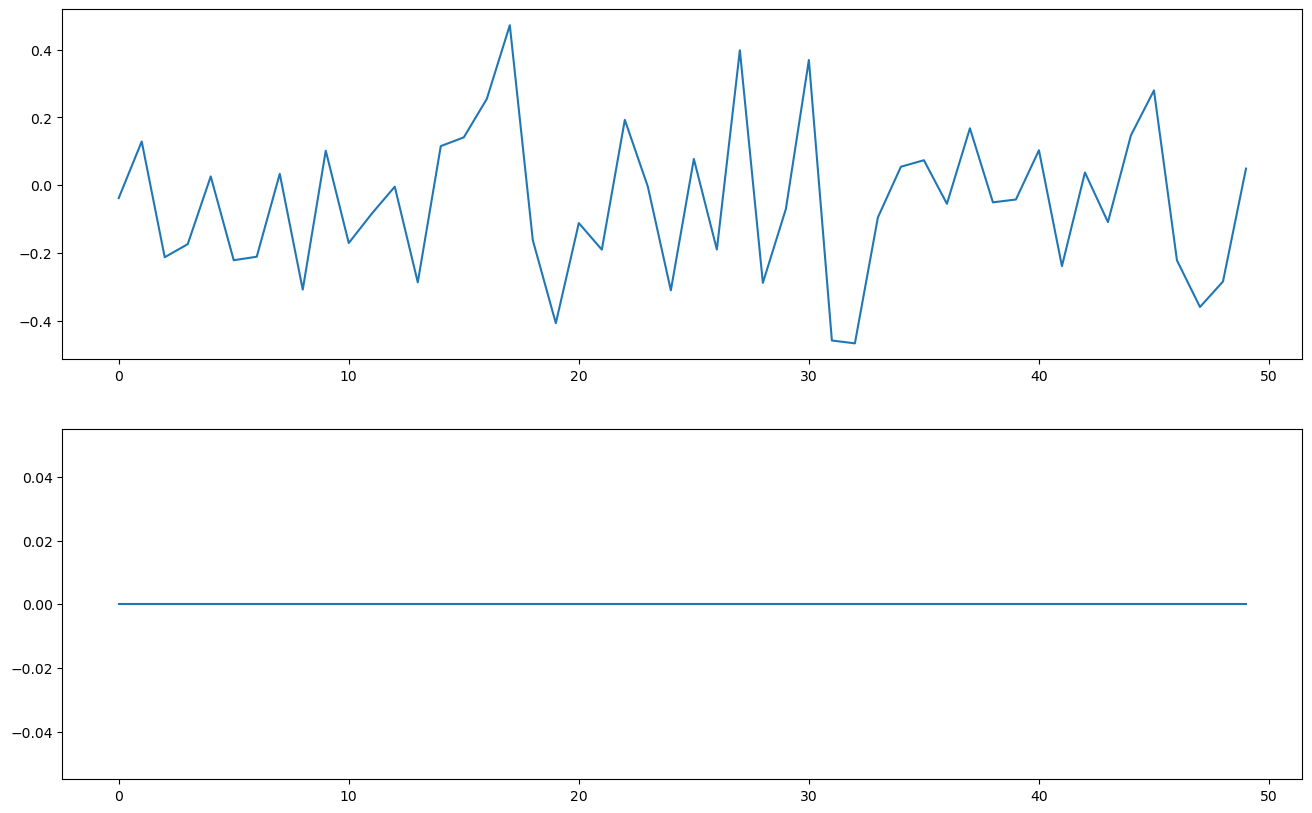

In [5]:
fig, axs = plt.subplots(nrows=2, figsize=(16, 10))
#just plot the first x!
axs[0].plot(x.numpy()[0].reshape(-1))
axs[1].plot(y.numpy()[0].reshape(-1))
plt.show()

Create the loss class
and just see if it works by calling with x as the data and y as the prediction

So it works and returns a suitable value; of course converted to a regular variable to print.

## Basic Stacked Autoencoder Implementation


---
A simple (encoder) NN model with just one layer and 10 fully connected neurones

In [6]:
# Encoder
input = tf.keras.layers.Input(shape=(x.shape[1]))
dense_1 = tf.keras.layers.Dense(10, activation='relu')(input)
encoder = tf.keras.models.Model(inputs=input, outputs=dense_1)
encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
dense (Dense)                (None, 10)                510       
Total params: 510
Trainable params: 510
Non-trainable params: 0
_________________________________________________________________


In [7]:
x.shape

TensorShape([500, 50])

...and a matching decoder....

In [8]:
# Decoder
input = tf.keras.layers.Input(shape=(10))
dense_1 = tf.keras.layers.Dense(x.shape[1], activation='linear')(input)
decoder = tf.keras.models.Model(inputs=input, outputs=dense_1)
decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                550       
Total params: 550
Trainable params: 550
Non-trainable params: 0
_________________________________________________________________


In [9]:
# AE

model2 = tf.keras.models.Sequential([
                                    encoder,
                                    decoder
])
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 10)                510       
_________________________________________________________________
model_1 (Functional)         (None, 50)                550       
Total params: 1,060
Trainable params: 1,060
Non-trainable params: 0
_________________________________________________________________


In [ ]:
class DtwLossKG(tf.keras.losses.Loss):
    def __init__(self): #can add other generic setups here like batch id desired
        super(DtwLossKG, self).__init__()
       # self.batch_size = batch_size
        self.r = tf.constant(20, dtype=tf.int32)
        
    def call(self, y_true, y_predict):
        LB_sum = tf.constant(0.0, dtype=tf.float32)  # Initialize the loss sum
        #for batch in range(self.batch_size):
        batch_size=y_predict.shape[0]
        #tf.print("y shape",y_predict.shape)
        for batch in range(batch_size):
            #tf.print(y_predict)
            #tf.print("x shape",y_true.shape)
            #tf.print("batch", batch)
            s1=y_true[batch,:]
            s2=y_predict[batch,:]
            for index in range(len(s1)):
                ind=tf.cast(index,dtype=tf.int32)
                i=tf.cast(s1[ind],dtype=tf.float32)
                #tf.print("s2=",s2)
                lower_bound = tf.reduce_min(s2[(ind - self.r if ind - self.r >= 0 else 0):\
                                               (ind + self.r if ind + self.r < len(s1) else len(s1))])
                upper_bound = tf.reduce_max(s2[(ind - self.r if ind - self.r >= 0 else 0):\
                                               (ind + self.r if ind + self.r < len(s1) else len(s1))])
                #tf.print("upper, lower",upper_bound, lower_bound)
                if i > upper_bound:
                    LB_sum += tf.abs(i - upper_bound)
                elif i < lower_bound:
                    LB_sum += tf.abs(i - lower_bound)

                #LB_sum += LB_sum 
        #tf.print("LB_sum=",LB_sum)
        return LB_sum/tf.cast(batch_size,dtype=tf.float32)
    
lossKG = DtwLossKG()
model2 = tf.keras.models.Sequential([
                                    encoder,
                                    decoder
])
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
              loss=lossKG)

history2=model2.fit(x, y, epochs=1000, batch_size=100)


Epoch 1/1000


In [ ]:
import math
fig, axs = plt.subplots(nrows=3, figsize=(16, 10))
axs[0].plot(x.numpy().reshape(-1))
axs[1].plot(model(x.numpy()).numpy().reshape(-1))
axs[2].plot(history2.history["loss"])
#axs[2].set_ylim([0,math.ceil(max(history2.history["loss"]))])
plt.show()